<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/70_IV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Data directories
train_dir = '/content/drive/MyDrive/DR_50_70/Train_70'
test_dir = '/content/drive/MyDrive/DR_50_70/Test_70'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load model for feature extraction
model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 2s 0us/step


In [4]:
# Function to extract features from an image
def extract_features_IV3net(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features

In [5]:
# Load images and extract features
x_train, y_train = [], []
for i in range(5):
    class_dir = os.path.join(train_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_IV3net(os.path.join(class_dir, img_path))
        x_train.append(features)
        y_train.append(i)

1/1 [==============================] - 0s 156ms/step


In [6]:
# Load images and extract features
x_test, y_test = [], []
for i in range(5):
    class_dir = os.path.join(test_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_IV3net(os.path.join(class_dir, img_path))
        x_test.append(features)
        y_test.append(i)

1/1 [==============================] - 0s 165ms/step


Training SVM with LINEAR kernel...
True Positives: 616
True Negatives: 2641
False Positives: 59
False Negatives: 59
Accuracy: 0.965037037037037
Precision: 0.9146493487906111
Specificity: 0.9781481481481481
Sensitivity: 0.9125925925925926
F1 Score: 0.9130069699973289
Recall: 0.9125925925925926



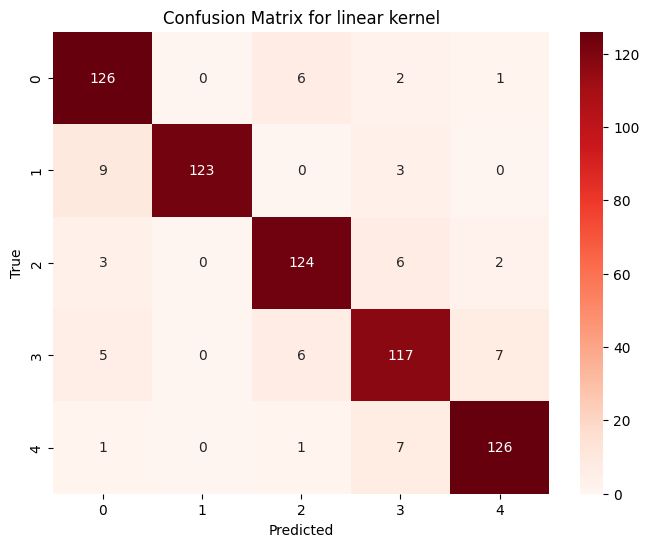

Training SVM with POLY kernel...
True Positives: 604
True Negatives: 2629
False Positives: 71
False Negatives: 71
Accuracy: 0.957925925925926
Precision: 0.8978613967776194
Specificity: 0.9737037037037037
Sensitivity: 0.8948148148148147
F1 Score: 0.895588537041867
Recall: 0.8948148148148147



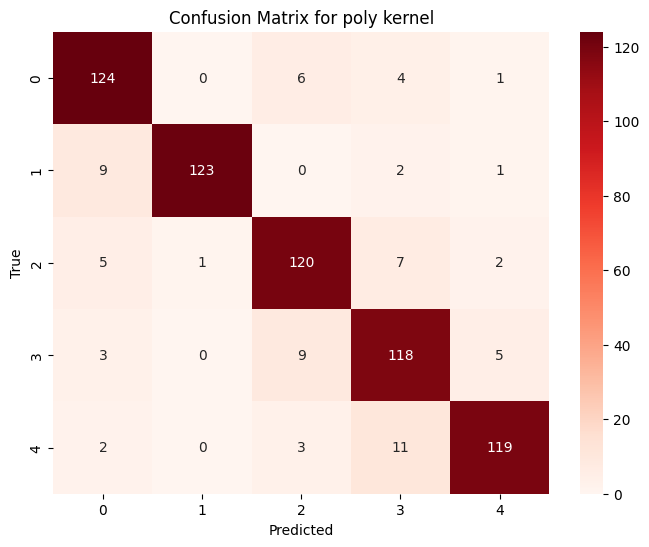

Training SVM with RBF kernel...
True Positives: 586
True Negatives: 2611
False Positives: 89
False Negatives: 89
Accuracy: 0.9472592592592592
Precision: 0.8730983428870751
Specificity: 0.967037037037037
Sensitivity: 0.868148148148148
F1 Score: 0.8692667881317512
Recall: 0.868148148148148



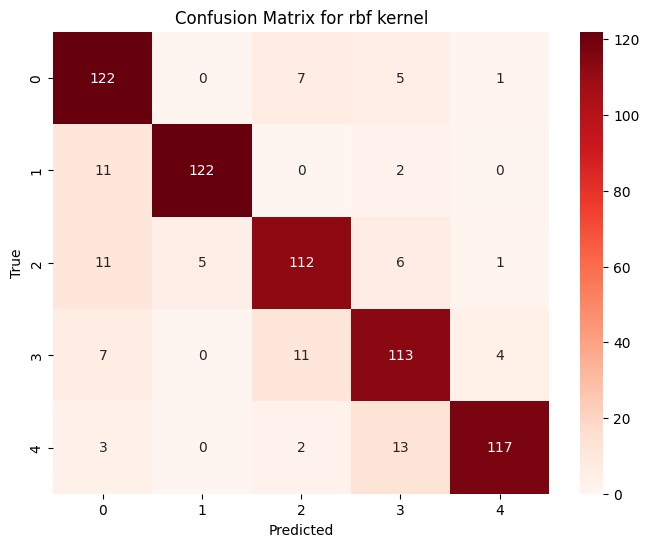

Training SVM with SIGMOID kernel...
True Positives: 517
True Negatives: 2542
False Positives: 158
False Negatives: 158
Accuracy: 0.9063703703703704
Precision: 0.7810455178235158
Specificity: 0.9414814814814815
Sensitivity: 0.7659259259259259
F1 Score: 0.7694726297105536
Recall: 0.7659259259259259



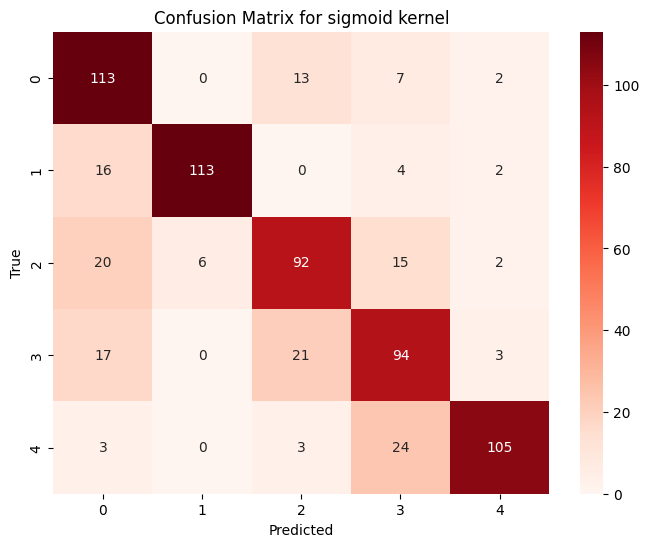

Training SVM with POLYNOMIAL_EXPONENTIAL kernel...
True Positives: 616
True Negatives: 2641
False Positives: 59
False Negatives: 59
Accuracy: 0.965037037037037
Precision: 0.9146493487906111
Specificity: 0.9781481481481481
Sensitivity: 0.9125925925925926
F1 Score: 0.9130069699973289
Recall: 0.9125925925925926



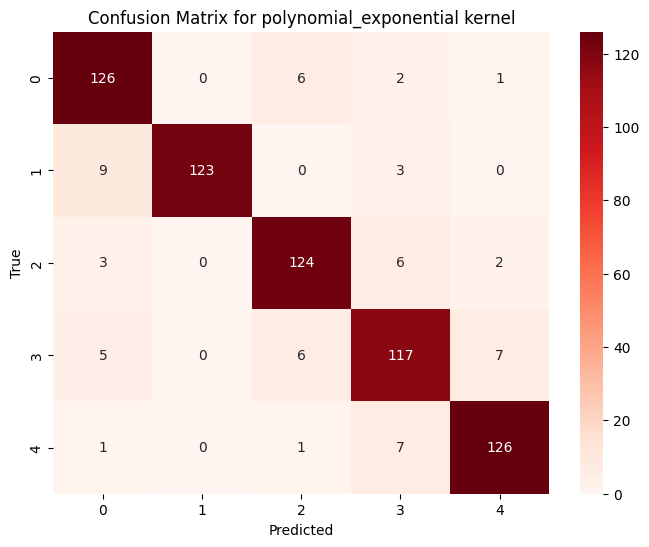

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns
from sklearn import svm, metrics

# Flatten the features
x_train_flat = np.array([feature.flatten() for feature in x_train])
x_test_flat = np.array([feature.flatten() for feature in x_test])

# List of kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'polynomial_exponential']

for kernel in kernels:
    print(f"\033[1mTraining SVM with {kernel.upper()} kernel...\033[0m")

    # Train SVM classifier
    if kernel == 'polynomial_exponential':
        clf = svm.SVC(kernel='precomputed')
        # Pre-compute the kernel matrix
        gram_train = np.dot(x_train_flat, x_train_flat.T)
        clf.fit(gram_train, y_train)
        gram_test = np.dot(x_test_flat, x_train_flat.T)
    else:
        clf = svm.SVC(kernel=kernel)
        clf.fit(x_train_flat, y_train)

    # Predict on test set
    if kernel == 'polynomial_exponential':
        y_pred = clf.predict(gram_test)
    else:
        y_pred = clf.predict(x_test_flat)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute TP, TN, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    num_classes = cm.shape[0]
    TN = []
    for i in range(num_classes):
        temp = np.delete(cm, i, 0)   # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))

    # Compute overall TP, TN, FP, FN
    overall_TP = np.sum(TP)
    overall_TN = np.sum(TN)
    overall_FP = np.sum(FP)
    overall_FN = np.sum(FN)

    # Compute accuracy, precision, specificity, sensitivity, F1-score, recall
    accuracy = (overall_TP + overall_TN) / (overall_TP + overall_TN + overall_FP + overall_FN)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = overall_TN / (overall_TN + overall_FP)

    # Print performance metrics
    print(f'True Positives: {overall_TP}')
    print(f'True Negatives: {overall_TN}')
    print(f'False Positives: {overall_FP}')
    print(f'False Negatives: {overall_FN}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Specificity: {specificity}')
    print(f'Sensitivity: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Recall: {recall}\n')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {kernel} kernel')
    plt.show()
